AIM: To perform intent classification using MLP and pretrained word embedding (glove).

In [ ]:
# import libraries
from google.colab import drive
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'model', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
testdf = pd.read_csv('test_.csv', usecols=['text','intent'])
validdf = pd.read_csv('valid_.csv', usecols=['text','intent'])

print('Train Shape: ', traindf.shape)
print('Test Shape: ', testdf.shape)
print('Valid Shape: ', validdf.shape)

Train Shape:  (9951, 2)
Test Shape:  (1280, 2)
Valid Shape:  (2985, 2)


Observation:

1.   No NULL value present.

In [ ]:
# NULL value presence check
print('NULL values: ', traindf['text'].isnull().sum())

NULL values:  0


Observation:

1.   Texts may not require a lot of text cleaning.

In [ ]:
# display first 10 rows
print('First 10 rows:\n', traindf.head(10))

First 10 rows:
                                                 text              intent
0                          find under night in-birth  SearchCreativeWork
1         book a spot in town in the same area as me      BookRestaurant
2                                         fimd glory  SearchCreativeWork
3       i need a restaurant on july 18th in rose bud      BookRestaurant
4  book a spot for 4 in oklahoma at south street ...      BookRestaurant
5  i need to know what the weather will be like i...          GetWeather
6  book a bistro in new zealand in 119 and a half...      BookRestaurant
7           need a table for nine in east prairie la      BookRestaurant
8  book a table for mindy and angelita at a resta...      BookRestaurant
9  find me a table for two at seven somewhere in ...      BookRestaurant


**Text Processing**

**Text Standardization, Tokenization, and Vectorization** (using tf.keras.layers.TextVectorization layer)

1.   Convert to lowercase. ✅
2.   Keep alphanumeric (remove punctuations if any). ✅
3.   Remove stopwords. ✅
4.   Perform stemming/lemmatization. ❌

In [ ]:
# function to perform standardization
@tf.keras.utils.register_keras_serializable() # if this line is not present; then the exported model will raise error while performing predictions
def custom_standardization(input_data): 
  lowercase = tf.strings.lower(input_data)
  remove_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
  remove_stopwords = tf.strings.regex_replace(remove_punctuation, r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '')
  return remove_stopwords

In [ ]:
# creating TextVectorization layer
max_features = 10000
sequence_length = 65

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# calling adapt on a text-only dataset (without labels) of training data
raw_train_ds = tf.data.Dataset.from_tensor_slices(traindf['text']).batch(64)
vectorize_layer.adapt(raw_train_ds)

In [ ]:
# get vocabulary size
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
print('Vocabulary size: {}'.format(voc))

Vocabulary size: ['', '[UNK]', 'play', 'book', 'add', 'find', 'playlist', '6', 'movie', 'rate', 'weather', 'show', 'give', 'restaurant', 'want', 'current', 'music', 'stars', 'forecast', 'points', 'playing', 'like', 'table', 'album', 'movies', 'song', 'need', 'please', 'one', 'called', '1', 'theatres', 'time', 'schedule', 'house', 'four', 'reservation', 'track', '3', '2', 'get', '4', 'two', '5', 'rating', 'put', 'people', 'tune', 'novel', 'five', 'three', 'animated', 'tv', 'times', '0', 'series', 'films', 'saga', 'cinema', 'party', 'artist', 'schedules', 'new', 'game', 'see', 'zero', 'serves', 'spot', 'best', 'closest', 'showing', 'nearest', 'hear', 'essay', 'textbook', 'list', 'would', 'area', 'theatre', 'tell', 'park', 'going', 'soundtrack', 'close', 'around', 'watch', 'top', 'songs', 'look', 'bar', 'chronicle', 'pm', 'food', 'love', 'nearby', 'last', 'eat', 'national', 'onto', 'state', 'search', 'place', 'rock', 'looking', 'picture', 'next', 'brasserie', 'television', 'within', 'rate

**Pre-trained Word Embedding: Glove**

In [ ]:
# prepare dictionary of word and it's embedding
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s Word Vectors." % len(embeddings_index))

Found 400000 Word Vectors.


In [ ]:
# prepare embedding matrix
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d Words (%d Misses)" % (hits, misses))

Converted 8352 Words (1086 Misses)


**Process Inputs**

In [ ]:
# text processing for all the x records (not on y records)
traindf['text'] = traindf['text'].apply(lambda x: vectorize_layer(x))
testdf['text'] = testdf['text'].apply(lambda x: vectorize_layer(x))
validdf['text'] = validdf['text'].apply(lambda x: vectorize_layer(x))

In [ ]:
# label encode 
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(traindf['intent']) # fit label encoder
print('Label Encoder Classes: ', label_encoder.classes_)

# transform labels
traindf['intent'] = label_encoder.transform(traindf['intent'])
testdf['intent'] = label_encoder.transform(testdf['intent'])
validdf['intent'] = label_encoder.transform(validdf['intent'])

Label Encoder Classes:  ['AddToPlaylist' 'BookRestaurant' 'GetWeather' 'PlayMusic' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']


In [ ]:
# convert model inputs to arrays
x_train = np.array([np.array(val) for val in traindf['text']])
x_val = np.array([np.array(val) for val in validdf['text']])

y_train = np.array([np.array(val) for val in traindf['intent']])
y_val = np.array([np.array(val) for val in validdf['intent']])

**MLP Training**

Model 1

In [ ]:
# model definition
model1 = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim,
                   embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.GlobalMaxPooling1D(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(7, activation='softmax')])
model1._name = 'ModelwithGloveEmbeddingAndGlobalMaxPool'
model1.summary()

Model: "ModelwithGloveEmbeddingAndGlobalMaxPool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         944000    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                           

In [ ]:
# model compiling
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 50
%time history = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/50
311/311 [==============================] - 1s 3ms/step - loss: 1.0708 - accuracy: 0.6202 - val_loss: 0.3994 - val_accuracy: 0.8774
Epoch 2/50
311/311 [==============================] - 1s 2ms/step - loss: 0.5023 - accuracy: 0.8351 - val_loss: 0.2857 - val_accuracy: 0.9052
Epoch 3/50
311/311 [==============================] - 1s 2ms/step - loss: 0.4055 - accuracy: 0.8652 - val_loss: 0.2374 - val_accuracy: 0.9186
Epoch 4/50
311/311 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.8877 - val_loss: 0.2220 - val_accuracy: 0.9216
Epoch 5/50
311/311 [==============================] - 1s 2ms/step - loss: 0.3290 - accuracy: 0.8900 - val_loss: 0.2060 - val_accuracy: 0.9270
Epoch 6/50
311/311 [==============================] - 1s 2ms/step - loss: 0.3112 - accuracy: 0.8974 - val_loss: 0.2028 - val_accuracy: 0.9307
Epoch 7/50
311/311 [==============================] - 1s 2ms/step - loss: 0.2934 - accuracy: 0.9031 - val_loss: 0.2018 - val_accuracy: 0.9276
Epoch 

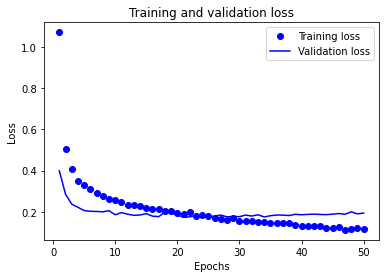

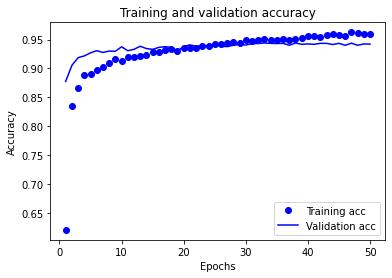

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Model 2

In [ ]:
# model definition
model2 = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim,
                   embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                   trainable=False),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(7, activation='softmax')])

model1._name = 'ModelwithGloveEmbeddingAndGlobalAvgPool'
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         944000    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
# model compiling
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 30
%time history = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/30
311/311 [==============================] - 1s 3ms/step - loss: 1.2684 - accuracy: 0.6195 - val_loss: 0.5010 - val_accuracy: 0.8747
Epoch 2/30
311/311 [==============================] - 1s 2ms/step - loss: 0.4575 - accuracy: 0.8551 - val_loss: 0.2794 - val_accuracy: 0.9156
Epoch 3/30
311/311 [==============================] - 1s 2ms/step - loss: 0.3222 - accuracy: 0.9007 - val_loss: 0.2178 - val_accuracy: 0.9296
Epoch 4/30
311/311 [==============================] - 1s 2ms/step - loss: 0.2683 - accuracy: 0.9143 - val_loss: 0.1925 - val_accuracy: 0.9377
Epoch 5/30
311/311 [==============================] - 1s 2ms/step - loss: 0.2378 - accuracy: 0.9250 - val_loss: 0.1734 - val_accuracy: 0.9444
Epoch 6/30
311/311 [==============================] - 1s 2ms/step - loss: 0.2226 - accuracy: 0.9272 - val_loss: 0.1612 - val_accuracy: 0.9484
Epoch 7/30
311/311 [==============================] - 1s 2ms/step - loss: 0.1981 - accuracy: 0.9381 - val_loss: 0.1566 - val_accuracy: 0.9467
Epoch 

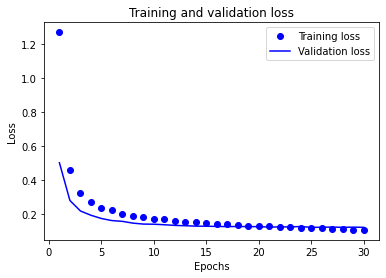

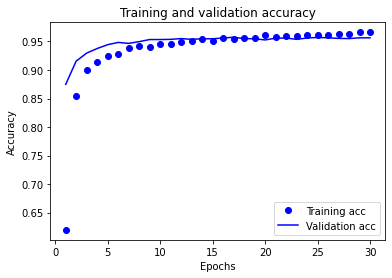

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Evaluate Model**

In [ ]:
# evaluate model on test dataset
x_test = np.array([np.array(val) for val in testdf['text']])
y_test = np.array([np.array(val) for val in testdf['intent']])
# model 1 evaluation
print('Model 1 Evaluation on Test Set:')
loss, accuracy = model1.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
# model 2 evaluation
print('\nModel 2 Evaluation on Test Set:')
loss, accuracy = model2.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Model 1 Evaluation on Test Set:
40/40 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9406
Loss:  0.22054710984230042
Accuracy:  0.940625011920929

Model 2 Evaluation on Test Set:
40/40 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.9563
Loss:  0.12067337334156036
Accuracy:  0.956250011920929


**Export Best Model**

In [ ]:
# save the model
export_model = tf.keras.Sequential([
  tf.keras.Input(shape=(1,), dtype="string"),
  vectorize_layer,
  model2 ]) # saving model 2

export_model.save('saved_model/model2_gloveencoding', save_format='tf')

**Conclusion:**

**Model 1:**

INPUT => EMBEDDING(Glove Embedding) => GMP1D => FC => RELU => DO => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 8,775
1.   Epochs: 50
2.   Loss and Accuracy:
    *   Training Loss: 0.1161 - Training Accuracy: 0.9604
    *   Validation Loss: 0.1941 - Validation Accuracy: 0.9420
    *   Testing Loss: 0.2205 - Testing Accuracy: 0.9406
3.   Wall Time: 36.8s
**Model 2:**

INPUT => EMBEDDING(Glove Embedding) => GAP1D => FC => RELU => DO => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 8,775
1.   Epochs: 30
2.   Loss and Accuracy:
    *   Training Loss: 0.1063 - Training Accuracy: 0.9661
    *   Validation Loss: 0.1215 - Validation Accuracy: 0.9564
    *   Testing Loss: 0.1206 - Testing Accuracy: 0.9562
3.   Wall Time: 22.1s

**ANALYSIS:**

1.   Model 2(uses GlobalAveragePool1D) is performing better than Model 1(uses GlobalMaxPool1D) in less epochs and in less wall time.